<a href="https://colab.research.google.com/github/makrez/neural_networks/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Autoencoders for the classification of DNA sequences

### Loading libraries

In [52]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import re
import os
#!pip install biopython
from Bio import SeqIO

from matplotlib import  pyplot as plt
import matplotlib.cm as cm
from matplotlib import collections  as mc
import matplotlib as mpl

import numpy as np
import pandas as pd
from imageio import imread
import pickle
from PIL import Image
from time import time as timer
import requests
import zipfile
import time
import os
import glob
import datetime

from scipy.stats import norm

import tensorflow as tf
import tensorflow.keras.datasets.mnist as mnist
from tensorflow.keras.layers import Layer, Dense, Conv2D, Conv2DTranspose, Flatten, Input, Reshape, Cropping2D, Embedding
from tensorflow.keras.layers import LeakyReLU

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML
from IPython.display import Audio
import IPython


#import umap
from scipy.stats import entropy
import sys
is_colab = 'google.colab' in sys.modules

tf.get_logger().setLevel('ERROR')

### Creating functions

In [76]:
class hot_dna:
 def __init__(self,fasta):
   
  #check for and grab sequence name
  if re.search(">",fasta):
   name = re.split("\n",fasta)[0]
   sequence = re.split("\n",fasta)[1]
  else :
   name = 'unknown_sequence'
   sequence = fasta
  
  #get sequence into an array
  seq_array = array(list(sequence))
    
  #integer encode the sequence
  label_encoder = LabelEncoder()
  integer_encoded_seq = label_encoder.fit_transform(seq_array)
    
  #one hot the sequence
  onehot_encoder = OneHotEncoder(sparse=False)
  #reshape because that's what OneHotEncoder likes
  integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)
  onehot_encoded_seq = onehot_encoder.fit_transform(integer_encoded_seq)
  
  #add the attributes to self 
  self.name = name
  self.sequence = fasta
  self.integer = integer_encoded_seq
  self.onehot = onehot_encoded_seq


# Flatten a list
def flatten(l):
    return [item for sublist in l for item in sublist]

def encode_dna(indices):
  category_indices = indices
  unique_category_count = 5
  inputs = tf.one_hot(category_indices, unique_category_count)
  return(inputs)



### Read data

In [ ]:
#from google.colab import files
#uploads = files.upload()

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
flatted_sequence = list()
sequence_labels = list()

with open('drive/MyDrive/Colab Notebooks/autoencoder_data/bacillus.aln') as handle:
  for record in SeqIO.parse(handle, 'fasta'):
    #seq = hot_dna(str(record.seq)[10:160]).integer
    #encoded = encode_dna(flatten(seq))
    label = str(record.description).rsplit(';', 1)[-1]
      
    #flatted_sequence.append(encoded)
    #flatted_sequence.append([tf.convert_to_tensor(flatten(hot_dna(str(record.seq)[10:160]).onehot))])
    seq_hot = flatten(hot_dna(str(record.seq)[10:160]).onehot)
    
    if len(seq_hot) == 750:
      flatted_sequence.append(seq_hot)
      sequence_labels.append(label)



In [ ]:
#print(flatted_sequence[1] == flatted_sequence[4])
#print(sequence_labels[1:5])
#print(len(flatted_sequence[1:10]))
#print(flatted_sequence[1].shape)
#my_hottie = hot_dna(">fake\nATTGC-G")
#encode_dna(flatten(my_hottie.integer))
# #print(tf.convert_to_tensor(flatted_sequence))
# print(input_label.shape)
# print(input_tensor.shape)


Split train and test data

In [79]:
from sklearn.model_selection import train_test_split
from collections import Counter

x_train, x_test, y_train, y_test = train_test_split(flatted_sequence, sequence_labels,test_size = 0.1)

print(f"The training set contains {len(x_train)} sequences")
print("The sequences are from the following species: ")
print(Counter(y_train))
print("---------------------------------")
print(f"The training set contains {len(x_test)} sequences")
print("The sequences are from the following species: ")
print(Counter(y_test))


The training set contains 2355 sequences
The sequences are from the following species: 
Counter({'Bacillus subtilis': 568, 'Bacillus velezensis': 482, 'Bacillus cereus': 387, 'Bacillus anthracis': 328, 'Bacillus thuringiensis': 233, 'Bacillus amyloliquefaciens': 134, 'Bacillus cytotoxicus': 121, 'Bacillus licheniformis': 102})
---------------------------------
The training set contains 262 sequences
The sequences are from the following species: 
Counter({'Bacillus subtilis': 72, 'Bacillus anthracis': 45, 'Bacillus cereus': 43, 'Bacillus velezensis': 40, 'Bacillus thuringiensis': 34, 'Bacillus licheniformis': 12, 'Bacillus amyloliquefaciens': 8, 'Bacillus cytotoxicus': 8})


In [102]:
# Convert train and test set to tensor:
input_tensor_train = tf.convert_to_tensor(x_train) 
input_tensor_test = tf.convert_to_tensor(x_test)

# Convert labels to tensor
le = LabelEncoder()
labels = le.fit_transform(y_train)
mapping = dict(zip(range(len(le.classes_)),le.classes_))
print(mapping)
input_label_train = tf.convert_to_tensor(labels) 

# le = LabelEncoder()
# labels = le.fit_transform(y_test)
# input_label_test = tf.convert_to_tensor(labels) 



{0: 'Bacillus amyloliquefaciens', 1: 'Bacillus anthracis', 2: 'Bacillus cereus', 3: 'Bacillus cytotoxicus', 4: 'Bacillus licheniformis', 5: 'Bacillus subtilis', 6: 'Bacillus thuringiensis', 7: 'Bacillus velezensis'}


In [ ]:
#x_trainx
#print(tf.convert_to_tensor(x_train))

## Define the Variational Autoencoder

In [81]:
class Sampling(Layer):
  def call(self,inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [82]:
# Define Encoder Model
latent_dim = 2

encoder_inputs = Input(shape =(750))
x = Flatten()(encoder_inputs)
x = Dense(150, activation = "relu")(x)
x = Dense(16, activation ="relu")(x)
z_mean = Dense(latent_dim, name ="z_mean")(x)
z_log_var = Dense(latent_dim, name ="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name ="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 750)]        0           []                               
                                                                                                  
 flatten_25 (Flatten)           (None, 750)          0           ['input_10[0][0]']               
                                                                                                  
 dense_45 (Dense)               (None, 150)          112650      ['flatten_25[0][0]']             
                                                                                                  
 dense_46 (Dense)               (None, 16)           2416        ['dense_45[0][0]']               
                                                                                            

In [83]:
# Define Decoder Architecture
latent_inputs = tf.keras.Input(shape =(latent_dim, ))
x = Dense(16, activation ="relu")(latent_inputs)
x = Dense(150, activation = "relu")(x)
x = Dense(750, activation = "sigmoid")(x)
decoder_outputs = Flatten()(x)
decoder = Model(latent_inputs, decoder_outputs, name ="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_47 (Dense)            (None, 16)                48        
                                                                 
 dense_48 (Dense)            (None, 150)               2550      
                                                                 
 dense_49 (Dense)            (None, 750)               113250    
                                                                 
 flatten_26 (Flatten)        (None, 750)               0         
                                                                 
Total params: 115,848
Trainable params: 115,848
Non-trainable params: 0
_________________________________________________________________


In [88]:
class VAE(tf.keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.decoder = decoder
    self.encoder = encoder

  def train_step(self, data):
    if isinstance(data, tuple):
      data = data[0]
      with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder(data)
        reconstruction = decoder(z)
        reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(data, reconstruction)
        )
        reconstruction_loss *= 28 * 28
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5
        total_loss = reconstruction_loss + kl_loss
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      return {
        "loss": total_loss,
        "reconstruction_loss": reconstruction_loss,
        "kl_loss": kl_loss,
        }

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer ='rmsprop')
vae.fit(x_train, x_train, epochs = 100, batch_size = 64)

In [113]:
print(mapping)

{0: 'Bacillus amyloliquefaciens', 1: 'Bacillus anthracis', 2: 'Bacillus cereus', 3: 'Bacillus cytotoxicus', 4: 'Bacillus licheniformis', 5: 'Bacillus subtilis', 6: 'Bacillus thuringiensis', 7: 'Bacillus velezensis'}


In [116]:
import matplotlib.colors as colors

def plot_label_clusters(encoder, decoder, data, test_lab):
  z_mean, _, _ = encoder.predict(data)
  plt.figure(figsize =(12, 10))
  sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c = test_lab)
  cbar = plt.colorbar(sc, ticks = range(10))
  cbar.ax.set_yticklabels([labels.get(i) for i in range(10)])
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.show()

74/74 [==============================] - 0s 2ms/step


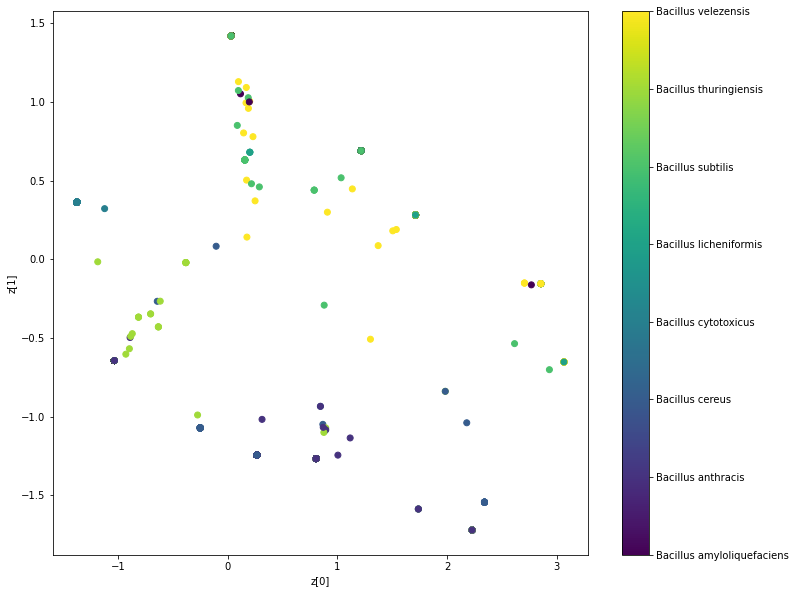

In [117]:
labels = mapping

plot_label_clusters(encoder, decoder, x_train, input_label_train)

### Increase the alignment size



In [121]:
flatted_sequence = list()
sequence_labels = list()

with open('drive/MyDrive/Colab Notebooks/autoencoder_data/bacillus.aln') as handle:
  for record in SeqIO.parse(handle, 'fasta'):
    #seq = hot_dna(str(record.seq)[10:160]).integer
    #encoded = encode_dna(flatten(seq))
    label = str(record.description).rsplit(';', 1)[-1]
      
    #flatted_sequence.append(encoded)
    #flatted_sequence.append([tf.convert_to_tensor(flatten(hot_dna(str(record.seq)[10:160]).onehot))])
    seq_hot = flatten(hot_dna(str(record.seq)[10:310]).onehot)
    
    if len(seq_hot) == 1500:
      flatted_sequence.append(seq_hot)
      sequence_labels.append(label)
  
x_train, x_test, y_train, y_test = train_test_split(flatted_sequence, sequence_labels,test_size = 0.01)

print(f"The training set contains {len(x_train)} sequences")
print("The sequences are from the following species: ")
print(Counter(y_train))
print("---------------------------------")
print(f"The training set contains {len(x_test)} sequences")
print("The sequences are from the following species: ")
print(Counter(y_test))


# Define Encoder Model
latent_dim = 2

encoder_inputs = Input(shape =(1500))
x = Flatten()(encoder_inputs)
x = Dense(150, activation = "relu")(x)
x = Dense(16, activation ="relu")(x)
z_mean = Dense(latent_dim, name ="z_mean")(x)
z_log_var = Dense(latent_dim, name ="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name ="encoder")
encoder.summary()

# Define Decoder Architecture
latent_inputs = tf.keras.Input(shape =(latent_dim, ))
x = Dense(16, activation ="relu")(latent_inputs)
x = Dense(150, activation = "relu")(x)
x = Dense(1500, activation = "sigmoid")(x)
decoder_outputs = Flatten()(x)
decoder = Model(latent_inputs, decoder_outputs, name ="decoder")
decoder.summary()

class VAE(tf.keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.decoder = decoder
    self.encoder = encoder

  def train_step(self, data):
    if isinstance(data, tuple):
      data = data[0]
      with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder(data)
        reconstruction = decoder(z)
        reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(data, reconstruction)
        )
        reconstruction_loss *= 28 * 28
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5
        total_loss = reconstruction_loss + kl_loss
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      return {
        "loss": total_loss,
        "reconstruction_loss": reconstruction_loss,
        "kl_loss": kl_loss,
        }

The training set contains 2590 sequences
The sequences are from the following species: 
Counter({'Bacillus subtilis': 633, 'Bacillus velezensis': 518, 'Bacillus cereus': 429, 'Bacillus anthracis': 366, 'Bacillus thuringiensis': 263, 'Bacillus amyloliquefaciens': 140, 'Bacillus cytotoxicus': 128, 'Bacillus licheniformis': 113})
---------------------------------
The training set contains 27 sequences
The sequences are from the following species: 
Counter({'Bacillus subtilis': 7, 'Bacillus anthracis': 7, 'Bacillus thuringiensis': 4, 'Bacillus velezensis': 4, 'Bacillus amyloliquefaciens': 2, 'Bacillus cytotoxicus': 1, 'Bacillus licheniformis': 1, 'Bacillus cereus': 1})
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 1500)]       0           []                               
            

In [122]:
vae = VAE(encoder, decoder)
vae.compile(optimizer ='rmsprop')
vae.fit(x_train, x_train, epochs = 100, batch_size = 64)

Epoch 1/100
41/41 [==============================] - 2s 15ms/step - loss: 114.6718 - reconstruction_loss: 87.8880 - kl_loss: 26.7838
Epoch 2/100
41/41 [==============================] - 1s 16ms/step - loss: 34.0666 - reconstruction_loss: 24.8892 - kl_loss: 9.1774
Epoch 3/100
41/41 [==============================] - 1s 15ms/step - loss: 26.1462 - reconstruction_loss: 22.4389 - kl_loss: 3.7074
Epoch 4/100
41/41 [==============================] - 1s 16ms/step - loss: 19.5757 - reconstruction_loss: 16.1723 - kl_loss: 3.4034
Epoch 5/100
41/41 [==============================] - 1s 14ms/step - loss: 13.0380 - reconstruction_loss: 10.0979 - kl_loss: 2.9401
Epoch 6/100
41/41 [==============================] - 1s 16ms/step - loss: 10.9687 - reconstruction_loss: 8.9730 - kl_loss: 1.9957
Epoch 7/100
41/41 [==============================] - 1s 15ms/step - loss: 10.1305 - reconstruction_loss: 8.6133 - kl_loss: 1.5172
Epoch 8/100
41/41 [==============================] - 1s 15ms/step - loss: 9.5112 - 

{0: 'Bacillus amyloliquefaciens', 1: 'Bacillus anthracis', 2: 'Bacillus cereus', 3: 'Bacillus cytotoxicus', 4: 'Bacillus licheniformis', 5: 'Bacillus subtilis', 6: 'Bacillus thuringiensis', 7: 'Bacillus velezensis'}
81/81 [==============================] - 0s 2ms/step


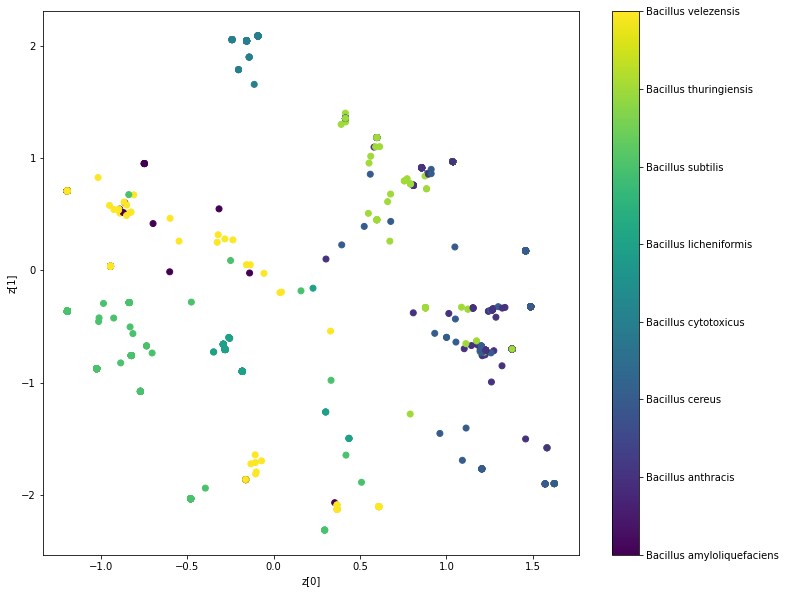

In [131]:
# Convert labels to tensor
le = LabelEncoder()
labels = le.fit_transform(y_train)
input_label_train = tf.convert_to_tensor(labels) 
mapping = dict(zip(range(len(le.classes_)),le.classes_))
print(mapping)
labels = mapping


plot_label_clusters(encoder, decoder, x_train, input_label_train)

In [130]:
print(len(x_train))
print(len(y_train))

2590
2590


## Increase more

In [132]:
flatted_sequence = list()
sequence_labels = list()

with open('drive/MyDrive/Colab Notebooks/autoencoder_data/bacillus.aln') as handle:
  for record in SeqIO.parse(handle, 'fasta'):
    #seq = hot_dna(str(record.seq)[10:160]).integer
    #encoded = encode_dna(flatten(seq))
    label = str(record.description).rsplit(';', 1)[-1]
      
    #flatted_sequence.append(encoded)
    #flatted_sequence.append([tf.convert_to_tensor(flatten(hot_dna(str(record.seq)[10:160]).onehot))])
    seq_hot = flatten(hot_dna(str(record.seq)[10:610]).onehot)
    
    if len(seq_hot) == 3000:
      flatted_sequence.append(seq_hot)
      sequence_labels.append(label)
  
x_train, x_test, y_train, y_test = train_test_split(flatted_sequence, sequence_labels,test_size = 0.01)

print(f"The training set contains {len(x_train)} sequences")
print("The sequences are from the following species: ")
print(Counter(y_train))
print("---------------------------------")
print(f"The training set contains {len(x_test)} sequences")
print("The sequences are from the following species: ")
print(Counter(y_test))


# Define Encoder Model
latent_dim = 2

encoder_inputs = Input(shape =(3000))
x = Flatten()(encoder_inputs)
x = Dense(150, activation = "relu")(x)
x = Dense(16, activation ="relu")(x)
z_mean = Dense(latent_dim, name ="z_mean")(x)
z_log_var = Dense(latent_dim, name ="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name ="encoder")
encoder.summary()

# Define Decoder Architecture
latent_inputs = tf.keras.Input(shape =(latent_dim, ))
x = Dense(16, activation ="relu")(latent_inputs)
x = Dense(150, activation = "relu")(x)
x = Dense(3000, activation = "sigmoid")(x)
decoder_outputs = Flatten()(x)
decoder = Model(latent_inputs, decoder_outputs, name ="decoder")
decoder.summary()

class VAE(tf.keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.decoder = decoder
    self.encoder = encoder

  def train_step(self, data):
    if isinstance(data, tuple):
      data = data[0]
      with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder(data)
        reconstruction = decoder(z)
        reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(data, reconstruction)
        )
        reconstruction_loss *= 28 * 28
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5
        total_loss = reconstruction_loss + kl_loss
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      return {
        "loss": total_loss,
        "reconstruction_loss": reconstruction_loss,
        "kl_loss": kl_loss,
        }

The training set contains 2578 sequences
The sequences are from the following species: 
Counter({'Bacillus subtilis': 621, 'Bacillus velezensis': 514, 'Bacillus cereus': 421, 'Bacillus anthracis': 373, 'Bacillus thuringiensis': 267, 'Bacillus amyloliquefaciens': 140, 'Bacillus cytotoxicus': 128, 'Bacillus licheniformis': 114})
---------------------------------
The training set contains 27 sequences
The sequences are from the following species: 
Counter({'Bacillus cereus': 9, 'Bacillus velezensis': 8, 'Bacillus subtilis': 5, 'Bacillus amyloliquefaciens': 2, 'Bacillus thuringiensis': 1, 'Bacillus anthracis': 1, 'Bacillus cytotoxicus': 1})
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 3000)]       0           []                               
                                         

In [133]:
vae = VAE(encoder, decoder)
vae.compile(optimizer ='rmsprop')
vae.fit(x_train, x_train, epochs = 100, batch_size = 64)

Epoch 1/100
41/41 [==============================] - 2s 24ms/step - loss: 111.8299 - reconstruction_loss: 85.3204 - kl_loss: 26.5095
Epoch 2/100
41/41 [==============================] - 1s 23ms/step - loss: 29.0388 - reconstruction_loss: 22.4152 - kl_loss: 6.6236
Epoch 3/100
41/41 [==============================] - 1s 23ms/step - loss: 19.2353 - reconstruction_loss: 15.3875 - kl_loss: 3.8478
Epoch 4/100
41/41 [==============================] - 1s 23ms/step - loss: 11.8317 - reconstruction_loss: 8.5649 - kl_loss: 3.2668
Epoch 5/100
41/41 [==============================] - 1s 23ms/step - loss: 9.9021 - reconstruction_loss: 7.5802 - kl_loss: 2.3220
Epoch 6/100
41/41 [==============================] - 1s 24ms/step - loss: 9.4648 - reconstruction_loss: 7.5391 - kl_loss: 1.9258
Epoch 7/100
41/41 [==============================] - 1s 23ms/step - loss: 9.3861 - reconstruction_loss: 7.5915 - kl_loss: 1.7946
Epoch 8/100
41/41 [==============================] - 1s 23ms/step - loss: 8.4673 - recon

{0: 'Bacillus amyloliquefaciens', 1: 'Bacillus anthracis', 2: 'Bacillus cereus', 3: 'Bacillus cytotoxicus', 4: 'Bacillus licheniformis', 5: 'Bacillus subtilis', 6: 'Bacillus thuringiensis', 7: 'Bacillus velezensis'}
81/81 [==============================] - 0s 3ms/step


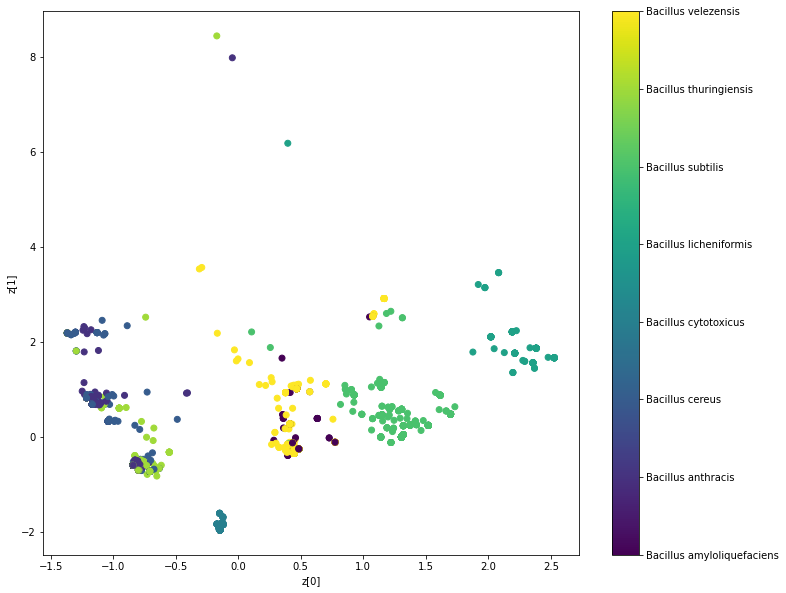

In [134]:
# Convert labels to tensor
le = LabelEncoder()
labels = le.fit_transform(y_train)
input_label_train = tf.convert_to_tensor(labels) 
mapping = dict(zip(range(len(le.classes_)),le.classes_))
print(mapping)
labels = mapping


plot_label_clusters(encoder, decoder, x_train, input_label_train)

In [135]:
flatted_sequence = list()
sequence_labels = list()

with open('drive/MyDrive/Colab Notebooks/autoencoder_data/bacillus.aln') as handle:
  for record in SeqIO.parse(handle, 'fasta'):
    #seq = hot_dna(str(record.seq)[10:160]).integer
    #encoded = encode_dna(flatten(seq))
    label = str(record.description).rsplit(';', 1)[-1]
      
    #flatted_sequence.append(encoded)
    #flatted_sequence.append([tf.convert_to_tensor(flatten(hot_dna(str(record.seq)[10:160]).onehot))])
    seq_hot = flatten(hot_dna(str(record.seq)[10:1210]).onehot)
    
    if len(seq_hot) == 6000:
      flatted_sequence.append(seq_hot)
      sequence_labels.append(label)
  
x_train, x_test, y_train, y_test = train_test_split(flatted_sequence, sequence_labels,test_size = 0.01)

print(f"The training set contains {len(x_train)} sequences")
print("The sequences are from the following species: ")
print(Counter(y_train))
print("---------------------------------")
print(f"The training set contains {len(x_test)} sequences")
print("The sequences are from the following species: ")
print(Counter(y_test))


# Define Encoder Model
latent_dim = 2

encoder_inputs = Input(shape =(6000))
x = Flatten()(encoder_inputs)
x = Dense(150, activation = "relu")(x)
x = Dense(16, activation ="relu")(x)
z_mean = Dense(latent_dim, name ="z_mean")(x)
z_log_var = Dense(latent_dim, name ="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name ="encoder")
encoder.summary()

# Define Decoder Architecture
latent_inputs = tf.keras.Input(shape =(latent_dim, ))
x = Dense(16, activation ="relu")(latent_inputs)
x = Dense(150, activation = "relu")(x)
x = Dense(6000, activation = "sigmoid")(x)
decoder_outputs = Flatten()(x)
decoder = Model(latent_inputs, decoder_outputs, name ="decoder")
decoder.summary()

class VAE(tf.keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.decoder = decoder
    self.encoder = encoder

  def train_step(self, data):
    if isinstance(data, tuple):
      data = data[0]
      with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder(data)
        reconstruction = decoder(z)
        reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(data, reconstruction)
        )
        reconstruction_loss *= 28 * 28
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5
        total_loss = reconstruction_loss + kl_loss
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      return {
        "loss": total_loss,
        "reconstruction_loss": reconstruction_loss,
        "kl_loss": kl_loss,
        }

The training set contains 2577 sequences
The sequences are from the following species: 
Counter({'Bacillus subtilis': 620, 'Bacillus velezensis': 515, 'Bacillus cereus': 427, 'Bacillus anthracis': 370, 'Bacillus thuringiensis': 264, 'Bacillus amyloliquefaciens': 140, 'Bacillus cytotoxicus': 128, 'Bacillus licheniformis': 113})
---------------------------------
The training set contains 27 sequences
The sequences are from the following species: 
Counter({'Bacillus velezensis': 6, 'Bacillus subtilis': 5, 'Bacillus cereus': 5, 'Bacillus anthracis': 5, 'Bacillus amyloliquefaciens': 2, 'Bacillus thuringiensis': 2, 'Bacillus cytotoxicus': 1, 'Bacillus licheniformis': 1})
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 6000)]       0           []                               
            

In [136]:
vae = VAE(encoder, decoder)
vae.compile(optimizer ='rmsprop')
vae.fit(x_train, x_train, epochs = 100, batch_size = 64)

Epoch 1/100
41/41 [==============================] - 3s 40ms/step - loss: 99.6135 - reconstruction_loss: 73.8290 - kl_loss: 25.7845
Epoch 2/100
41/41 [==============================] - 2s 38ms/step - loss: 24.9274 - reconstruction_loss: 16.9714 - kl_loss: 7.9561
Epoch 3/100
41/41 [==============================] - 2s 38ms/step - loss: 17.9574 - reconstruction_loss: 13.5639 - kl_loss: 4.3936
Epoch 4/100
41/41 [==============================] - 2s 39ms/step - loss: 11.4846 - reconstruction_loss: 8.1147 - kl_loss: 3.3699
Epoch 5/100
41/41 [==============================] - 2s 38ms/step - loss: 10.6664 - reconstruction_loss: 7.6938 - kl_loss: 2.9726
Epoch 6/100
41/41 [==============================] - 2s 39ms/step - loss: 9.6642 - reconstruction_loss: 7.1387 - kl_loss: 2.5255
Epoch 7/100
41/41 [==============================] - 2s 38ms/step - loss: 9.7872 - reconstruction_loss: 7.3694 - kl_loss: 2.4177
Epoch 8/100
41/41 [==============================] - 2s 38ms/step - loss: 8.2952 - recon

{0: 'Bacillus amyloliquefaciens', 1: 'Bacillus anthracis', 2: 'Bacillus cereus', 3: 'Bacillus cytotoxicus', 4: 'Bacillus licheniformis', 5: 'Bacillus subtilis', 6: 'Bacillus thuringiensis', 7: 'Bacillus velezensis'}
81/81 [==============================] - 0s 4ms/step


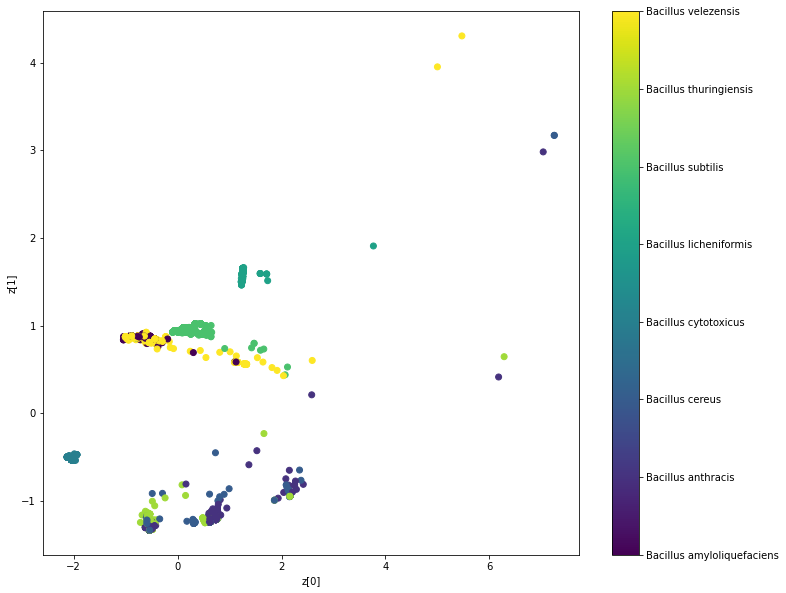

In [137]:
# Convert labels to tensor
le = LabelEncoder()
labels = le.fit_transform(y_train)
input_label_train = tf.convert_to_tensor(labels) 
mapping = dict(zip(range(len(le.classes_)),le.classes_))
print(mapping)
labels = mapping


plot_label_clusters(encoder, decoder, x_train, input_label_train)